# Championship Predictor

The goal of this project will be to see how well I can train different machine learning models to predict the outcome of Championship games in the English second division given match statistics of the game including variables such as: total shots, shots on target, corner, fouls committed, and freekicks commited for each team.

I will first train the models based on match statistics only then I will compare how the models perform when I include the odds on each game made by various betting companies.

With my previous knowledge of how much luck plays a part in the outcomes of games, I predict that it will be hard for a machine learning model to predict the outcome just based of off match statistics. I think the models will have at best around 50% accuracy.

The first step in this process will be to import the necessary packages and read the [data](https://www.football-data.co.uk/data.php) provided from football-data.co.uk and preprocess the data so that it will be ready to train the models I chose.

## Data Extraction and Preprocessing

In [23]:
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [24]:
#Here I will import the last five years of data collected from the Championiship league
df1 = pd.read_csv('E1.csv')
df2 = pd.read_csv('E1 (2).csv')
df3 = pd.read_csv('E1 (3).csv')
df4 = pd.read_csv('E1 (4).csv')

Now I will put together all of the dataframes together

In [25]:
data = [df1,df2,df3,df4]
data = pd.concat(data, sort = False)

Now I will seperate the match statistics from the dataframe in order to not rely on different betting companies' betting odds on each game.

In [26]:
data = data.iloc[:,:23]

Now I will check to see if all of the possible data is filled out which is to say I will find out if there are any existing NaN values.

In [27]:
data.isna().sum()

Div         0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        1
HTAG        1
HTR         1
Referee     1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
dtype: int64

Here it looks like there is probably just one match that is missing the data so we will get rid of this game and reset the index to account for the newly missing index.

In [28]:
data.dropna(axis=0,how='any',inplace = True)
data = data.reset_index() #Reset indices to accomodate 
data

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,0,E1,03/08/2018,Reading,Derby,1,2,A,0.0,0.0,...,5.0,3.0,14.0,16.0,2.0,4.0,3.0,4.0,0.0,0.0
1,1,E1,04/08/2018,Birmingham,Norwich,2,2,D,0.0,0.0,...,7.0,7.0,15.0,10.0,4.0,4.0,0.0,3.0,0.0,0.0
2,2,E1,04/08/2018,Brentford,Rotherham,5,1,H,2.0,0.0,...,10.0,5.0,15.0,10.0,13.0,3.0,0.0,2.0,0.0,0.0
3,3,E1,04/08/2018,Bristol City,Nott'm Forest,1,1,D,1.0,0.0,...,6.0,6.0,8.0,17.0,7.0,9.0,0.0,4.0,0.0,0.0
4,4,E1,04/08/2018,Ipswich,Blackburn,2,2,D,1.0,2.0,...,3.0,2.0,11.0,21.0,3.0,0.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,547,E1,07/05/16,Middlesbrough,Brighton,1,1,D,1.0,0.0,...,5.0,1.0,13.0,16.0,4.0,4.0,0.0,3.0,0.0,1.0
2203,548,E1,07/05/16,Milton Keynes Dons,Nott'm Forest,1,2,A,1.0,1.0,...,4.0,5.0,10.0,12.0,7.0,5.0,0.0,1.0,0.0,1.0
2204,549,E1,07/05/16,Preston,Leeds,1,1,D,0.0,0.0,...,5.0,2.0,10.0,9.0,7.0,6.0,0.0,0.0,0.0,0.0
2205,550,E1,07/05/16,QPR,Bristol City,1,0,H,0.0,0.0,...,6.0,2.0,12.0,12.0,7.0,11.0,0.0,0.0,0.0,0.0


As expected only one game was removed.

Now I will remove the "index" and "Div" columns since all teams are in the same division and the index column is redundant

In [29]:
data = data.iloc[:,2:]

Here I will separate the final result as well as the full time home and away goals since these are things I will want to predict. I will also remove the date since the problem I am focussing on is solely whether or not the statistics from a game are good predictors of the outcome of the game.

In [30]:
#Label encoding the results
Result = {"HTR":{'H': 1, 'D': 0, 'A':-1},
         "FTR":{'H': 1, 'D': 0, 'A':-1}}
data.replace(Result,inplace=True)


In [31]:
FTR = data['FTR']
FTR=pd.DataFrame(FTR)
match_data = data.drop(['FTHG', 'FTAG', 'FTR','Date'],axis=1)

Now I will label encode all of the teams and the referee names by first joining them all into one array and then using label_encoder on them so that each unique value will have its own label.

In [32]:
home = match_data['HomeTeam']
away = match_data['AwayTeam']
reff = match_data['Referee']
labeltheseteams = home.append(away)
label_encoder = preprocessing.LabelEncoder()
labeled_reffs = label_encoder.fit_transform(reff)
labeled_teams = label_encoder.fit_transform(labeltheseteams)
homeID = labeled_teams[:2207]
homeID = pd.DataFrame(homeID)
homeID.rename(columns={0:'HomeID'}, inplace=True)
awayID = labeled_teams[2207:]
awayID = pd.DataFrame(awayID)
awayID.rename(columns={0:'AwayID'}, inplace=True)
reffID = labeled_reffs
reffID = pd.DataFrame(reffID)
reffID.rename(columns={0:'ReffID'}, inplace=True)
match_data = pd.concat([homeID, awayID, reffID, match_data], axis=1)
d = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
print(d)  #Here I am printing the values of the lebel encoded teams so that I can reference 
          #them later.

{'Aston Villa': 0, 'Barnsley': 1, 'Birmingham': 2, 'Blackburn': 3, 'Bolton': 4, 'Brentford': 5, 'Brighton': 6, 'Bristol City': 7, 'Burnley': 8, 'Burton': 9, 'Cardiff': 10, 'Charlton': 11, 'Derby': 12, 'Fulham': 13, 'Huddersfield': 14, 'Hull': 15, 'Ipswich': 16, 'Leeds': 17, 'Middlesbrough': 18, 'Millwall': 19, 'Milton Keynes Dons': 20, 'Newcastle': 21, 'Norwich': 22, "Nott'm Forest": 23, 'Preston': 24, 'QPR': 25, 'Reading': 26, 'Rotherham': 27, 'Sheffield United': 28, 'Sheffield Weds': 29, 'Stoke': 30, 'Sunderland': 31, 'Swansea': 32, 'West Brom': 33, 'Wigan': 34, 'Wolves': 35}


Now the match_data contains all of the information we want for out model

Now I'll specify what it is we want to find which is the full time result

In [33]:
#Here I drop the original columns that I coppied and made into label encoded data
match_data = match_data.drop(['HomeTeam', 'AwayTeam', 'Referee'],axis=1)

# ML method 1 : SVM

In [34]:
match_data

,HomeID,AwayID,ReffID,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,26,12,65,0.0,0.0,0,8.0,11.0,5.0,3.0,14.0,16.0,2.0,4.0,3.0,4.0,0.0,0.0
1,2,22,59,0.0,0.0,0,16.0,16.0,7.0,7.0,15.0,10.0,4.0,4.0,0.0,3.0,0.0,0.0
2,5,27,58,2.0,0.0,1,14.0,9.0,10.0,5.0,15.0,10.0,13.0,3.0,0.0,2.0,0.0,0.0
3,7,23,13,1.0,0.0,1,18.0,16.0,6.0,6.0,8.0,17.0,7.0,9.0,0.0,4.0,0.0,0.0
4,16,3,0,1.0,2.0,-1,9.0,6.0,3.0,2.0,11.0,21.0,3.0,0.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,18,6,51,1.0,0.0,1,13.0,7.0,5.0,1.0,13.0,16.0,4.0,4.0,0.0,3.0,0.0,1.0
2203,20,23,73,1.0,1.0,0,20.0,10.0,4.0,5.0,10.0,12.0,7.0,5.0,0.0,1.0,0.0,1.0
2204,24,17,6,0.0,0.0,0,16.0,10.0,5.0,2.0,10.0,9.0,7.0,6.0,0.0,0.0,0.0,0.0
2205,25,7,35,0.0,0.0,0,17.0,17.0,6.0,2.0,12.0,12.0,7.0,11.0,0.0,0.0,0.0,0.0


In [35]:
#Here I test the model by performing a simple train test split and 
#finding the accuracy to get a general idea of how well the model fairs:

X_train, X_test, y_train, y_test = train_test_split(match_data, FTR.values.ravel(), test_size = 0.2)
model_svm = SVC(kernel = 'linear')
model_svm.fit(X_train, y_train)
model_svm.score(X_test, y_test)

0.6244343891402715

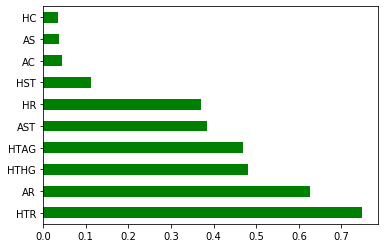

In [36]:
pd.Series(abs(model_svm.coef_[0]), index=match_data.columns).nlargest(10).plot(kind='barh',color='green')

Above we can see which features had the greatest importance in our model. As can be expected, the number of goals scored by each team would be a key factor in who the winner is at the end of the game.

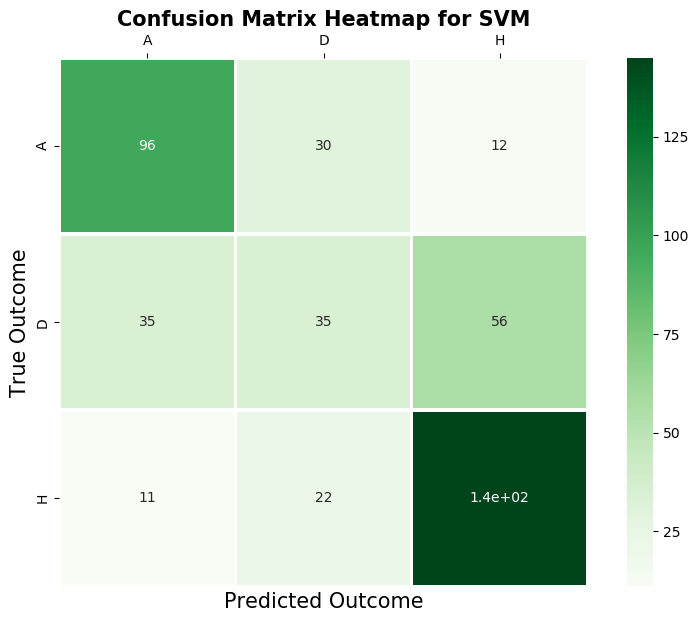

In [37]:
pred = model_svm.predict(X_test)
fig = plt.figure(figsize=(10,7), dpi=100)

cm_heatmap = sns.heatmap(confusion_matrix(y_test,pred),annot = True, cmap="Greens", linewidths = 2, square=True)

xlabels = ['A','D','H']
cm_heatmap.set_xticklabels(xlabels)
ylabels = ['A','D','H']
cm_heatmap.set_yticklabels(ylabels)

cm_heatmap.set_ylim([0,3])
cm_heatmap.invert_yaxis()

cm_heatmap.set_title('Confusion Matrix Heatmap for SVM', fontsize=15, fontweight='bold')
cm_heatmap.set_xlabel('Predicted Outcome', fontsize=15)
cm_heatmap.set_ylabel('True Outcome', fontsize=15)
cm_heatmap.xaxis.set_ticks_position('top')



plt.show()

Interestingly we can see that the model was best at predicting whether or not a team won, but struggled to predict draws.

Note: The heatmap shows as cut-off on the top and bottom because of a current 

In [38]:
#Here I get a better gauge of how well the model performed by performing
#Cross-Validation with 5 splits

svm = SVC(kernel = 'linear')
scores = cross_val_score(svm, match_data, FTR.values.ravel(), cv=10)
print('Accuracy:%.02f (+/- %0.2f)'%(scores.mean(), scores.std()*2))

Accuracy:0.64 (+/- 0.06)


64% is a rather good prediction accuracy score knowinghow random games can be and how many upsets happen a year. I would like ot look further and find out how important each feature is in making the predictions.

By using a SVM with a linear kernel type out model was able to reach about 64% accuracy. Out of interest I will perform PCA on the data to see if there is any imporvement.

In [39]:
normX = (match_data-match_data.mean())/match_data.std()
X_PCA = PCA() #Specifying that we want to maintain 90% energy 
                               #capture of the original dataset.
X_PCA = X_PCA.fit_transform(normX)
X_PCAdf = pd.DataFrame(X_PCA)

In [40]:
scores_PCA = cross_val_score(svm, X_PCAdf, FTR.values.ravel(), cv=5)
print('Accuracy:%.02f (+/- %0.2f)'%(scores_PCA.mean(), scores_PCA.std()*2))

Accuracy:0.64 (+/- 0.06)


Interestingly PCA slightly decreased the accuracy of SVM. This may be explained by the fact there wasn't much need for further feature reduction/extraction and by reducing the features futher we lost important information.

# ML method 2 : K-NN 

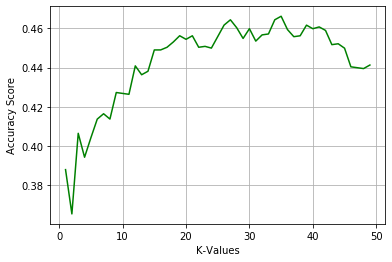

In [41]:
#First I will find the best possible k value for K-NN

k_values = [i for i in range(1,50)]
k_acc_scores = []

for k in k_values: #For K values ranging from 1 to 50
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn, match_data, FTR.values.ravel(), cv = 5, 
                                scoring = 'accuracy')
    k_acc_scores.append(cv_scores.mean())
    
optimal_k = k_values[k_acc_scores.index(max(k_acc_scores))]
plt.plot(k_values, k_acc_scores, color = 'green')
plt.grid(True)

plt.xlabel('K-Values')
plt.ylabel('Accuracy Score')

plt.show()

In [42]:
optimal_k

35

In [43]:
KNN = KNeighborsClassifier(n_neighbors = 35)

KNN_scores = cross_val_score(KNN, match_data, FTR.values.ravel(), cv = 10, scoring = 'accuracy')
print('Accuracy:%.02f (+/- %0.2f)'%(KNN_scores.mean(), KNN_scores.std()*2))

Accuracy:0.46 (+/- 0.06)


SVM is clearly better than KNN at predicting the outcomes of matches. 

# Method 3 : Linear Regression

In [44]:
LinearR = LinReg()
LinReg_scores = cross_val_score(LinearR, match_data, FTR, cv=5)
print('Accuracy:%.02f (+/- %0.2f)'%(LinReg_scores.mean(), LinReg_scores.std()*2))

Accuracy:0.45 (+/- 0.08)


Here we can see that linear regression performed the worst out of the three methods.

# Conclusion

Out of all the machine learning methods (SVM ~64%, K-NN ~46%, and Linear Regression ~45%) we can see that SVM by far was the best performing method.
It is interesting to see that by using the match data we can predict the final result with over 50% accuracy which is better than I predicted.

My prior knowledge of the sport made me  believe that getting a score of over 50% may be challenging because I know that the statistics of the game often don't tell the whole story. I knew that chance and luck are massive features in the sport of Soccer and it is interesting to see how well the models I trained performed. Furthermore, I also knew that home teams win about 46% of the time and this fact helps explain why my model was so good at predicted when the home team would win. 

Unfortunately the possession statistics weren't in the dataset. I have previously studied which statistcs show correlations with the end of game result and possession has been recorded to be a rather good one. In a future project I will try to find out if any single statistic such as possession, or half time result, will be enough to train a machine learning model to predict the outcome of a game with an accuracy score of hopefully over 50%.